Volume Fraction 0.700
Box Dimensions 15.184
Loaded data...
0.0001 1498.0 92.1225956049
0.0002 1.0 26.2941981421
0.0003 1.0 19.7055354651
0.0005 1.0 14.4349521554
0.001 1.0 10.4783658205
0.002 1.0 8.49007433224
0.003 1.0 7.81331604426
0.005 1.0 7.25398785557
0.01 1.0 6.77134763266
0.032 3.0 17.9561834604
0.055 10.0 53.2660778543
0.1 30.0 125.438378937
0.18 58.0 176.280188541
0.22 81.0 210.678489213
0.32 312.0 380.119764535
0.46 357.0 326.675934858
0.55 391.0 290.890812593
1.0 446.0 180.894243587
1.8 491.0 122.754786516
3.2 560.0 74.3224582354
10.0 620.0 25.0033824742
Time: 2.711 s
Volume Fraction 0.700
Box Dimensions 15.184
Loaded data...
0.0001 1498.0 126.877707301
0.001 1.0 12.1991581156
0.01 1.0 6.91143784929
0.032 4.0 24.0765983503
0.1 32.0 134.239837755
0.2 85.0 229.453239387
1.0 437.0 186.344845399
10.0 620.0 24.54297297
Time: 3.540 s
Volume Fraction 0.700
Box Dimensions 15.184
Loaded data...
0.0001 1498.0 86.6908313012
0.001 1.0 10.1971857343
0.01 1.0 6.73977695383
0.032 3.0 17.9

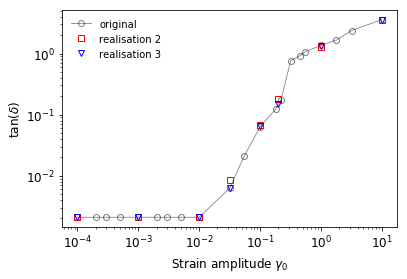

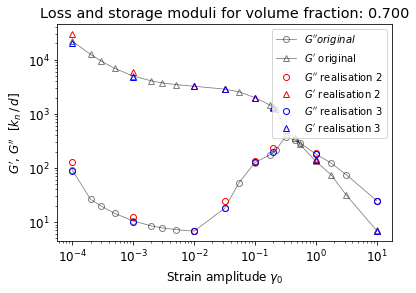

[  86.6908313    10.19718573    6.73977695   17.93076893  128.59722898
  199.52085868  182.58650596   24.72965432]


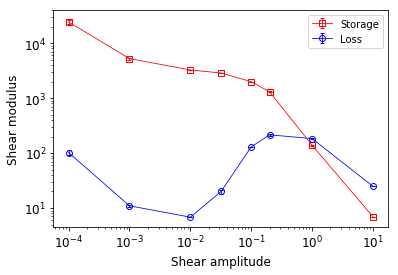

Completed...
Time: 7.747 s


In [6]:
import time
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt
from os import listdir
import re
start = time.time()
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)


# function to read datafile
def get_all_data(filename):
# read text file and store each line as element of list
    with open(filename) as f:
        raw = f.readlines()
        f.close()
    raw = [x.strip() for x in raw]
    
    s = 0
    e = len(raw) - 1
    for k in range(len(raw)):
        if 'Time' in raw[k]:
            s = k + 1
        elif 'Loop' in raw[k]:
            e = k - 1
    #print(e - s)

# create array of data for each timestep
    all_data = []
# discards first and last info lines and split each line of data into a list of floats
    for j in range(len(raw)):
        if s <= j <= e:
            all_data.append(list(map(float, raw[j].split())))
            
    return all_data


# function to execute main part of the code
def extract_data(file, data_path):

# extracts time, contact and hydro stresses and strain from datafile
    datafile = '%s/%s' % (data_path, file)
    all_data = get_all_data(datafile)
    
    t = np.zeros(len(all_data))
    sc_xz = np.zeros(len(all_data))
    sh_xz = np.zeros(len(all_data))
    #strain = np.zeros(len(all_data))
    
    for i in range(len(all_data)):
        t[i] = all_data[i][0]
        sc_xz[i] = -all_data[i][1]
        sh_xz[i] = -all_data[i][2]
        #strain[i] = all_data[i][7]

    return t, sc_xz, sh_xz


def tryfloat(s):
    try:
        return float(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    amp = s[14:-4]
    amp = float(amp)
    #breakdown = [ tryfloat(c) for c in re.split('([0-9]+)', s) ]
    return amp

def alphanum_key_repeat(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    amp = s[14:-12]
    amp = float(amp)
    #breakdown = [ tryfloat(c) for c in re.split('([0-9]+)', s) ]
    return amp


def calc_signal_lag(a_sig, b_sig, thermo_nt):
    lag = np.argmax(correlate(a_sig, b_sig, mode='full'))
    steps = int(period / (timestep * thermo_nt))
    mod_lag = lag % steps
    if mod_lag > int(steps/2) or mod_lag == 0:
        mod_lag = 1.0
        
    return mod_lag


def plot_signals_vs_time(t, a_sig, b_sig, lag, phase_diff, shear_amp, fig_path, l1, l2):
    # shifts strain by lag to check if aligned with stress now
    c_sig = np.roll(b_sig, shift = -lag)

    plt.figure()
    plt.title('Stress and Strain vs Time for Shear Amplitude: %g' % (shear_amp))
    plt.plot(t[l1:l2], a_sig[l1:l2], color='blue', label='Stress')
    plt.plot(t[l1:l2], b_sig[l1:l2], color='green', label='Strain')
    plt.plot(t[l1:l2], c_sig[l1:l2], color='red', label='Shifted Strain', alpha=0.5)
    plt.xlabel('t')
    plt.ylabel('Stress')
    plt.legend(loc='best')
    plt.savefig('%s/stress_strain_vs_t_%s.png' % (fig_path, shear_amp))
    plt.close()
    
    return None


def plot_stress_vs_strain(stress, strain, shear_amp, fig_path):
    
    plt.figure()
    plt.title('Stress vs Strain for Shear Amplitude: %g' % (shear_amp))
    plt.plot(strain, stress, color='blue')
    plt.xlabel('Normalised Strain')
    plt.ylabel('Normalised Hydrodynamic Stress')
    plt.savefig('%s/stress_vs_strain_%s.png' % (fig_path, shear_amp))
    plt.close()
    
    return None


def calc_macro_reversibility(vol_frac, repeat):
    print('Volume Fraction %.3f' % vol_frac)
    print('Box Dimensions %g' % box_dim)
    
    data_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_data/volume_fraction_%.3f' % vol_frac
    fig_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_plots/volume_fraction_%.3f' % vol_frac
    all_files = listdir(data_path)
    files = []
    if repeat < 1:
        for file in all_files:
            if ".log" in file and "repeat" not in file and "large" not in file and "super" not in file:
                files.append(file)
        files.sort(key=alphanum_key)
    else:
        for file in all_files:
            if ".log" in file and "repeat%i" % r in file and "large" not in file and "super" not in file:
                files.append(file)
        files.sort(key=alphanum_key_repeat)

    
    shear_amps = np.zeros(len(files))
    
    if repeat < 1:
        for i in range(len(files)):
            shear_amps[i] = (float(files[i][14:-4]))
    else:
        for i in range(len(files)):
            shear_amps[i] = (float(files[i][14:-12]))

    ts = []
    sc_xzs = []
    sh_xzs = []
    strains = []
    shear_rates = []
    stokes_nos = np.zeros(len(files))
    total_stresses = []
    norm_strains = []
    norm_stresses = []

    for i in range(len(files)):
        #print('Shear Amplitude: %s' % shear_amps[i])
        t, sc_xz, sh_xz = extract_data(files[i], data_path)
        strain = shear_amps[i] * np.sin(freq * t)
        ts.append(t)
        sc_xzs.append(sc_xz)
        sh_xzs.append(sh_xz)
        strains.append(strain)
        shear_rates.append(freq * shear_amps[i] * np.cos(freq * t))
        stokes_nos[i] = (density * np.absolute(shear_rates[i]).max() * particle_r ** 2) / viscosity
        total_stresses.append(sc_xz + sh_xz)
        norm_strains.append(strain / np.absolute(strain[exclude:]).max())
        norm_stresses.append((sh_xz + sc_xz) / np.absolute(sh_xz[exclude:] + sc_xz[exclude:]).max())
    
    ts = np.array(ts)
    sc_xzs = np.array(sc_xzs) # xz component of contact stresses
    sh_xzs = np.array(sh_xzs) # xz component of hydrodynamic stresses
    strains = np.array(strains)
    shear_rates = np.array(shear_rates)
    total_stresses = np.array(total_stresses)
    norm_strains = np.array(norm_strains) # normalised shear strains
    norm_stresses = np.array(norm_stresses) # normalised hydrodynamic stresses
    
    #print('Shear Amplitudes: %a' % (np.array(shear_amps) / box_dim))
    #print('Stokes Numbers: %a' % stokes_nos)
    #print('Shear Rate Amplitudes: %a' % (np.array(shear_amps) / box_dim * freq))
    print('Loaded data...')
    

    lags = np.zeros(len(shear_amps))
    lag_times = np.zeros(len(shear_amps))
    phase_diffs = np.zeros(len(shear_amps))
    loss_moduli = np.zeros(len(shear_amps))
    storage_moduli = np.zeros(len(shear_amps))

    for i in range(len(shear_amps)):
        thermo_nt = 1000
        l1 = - int(3 * period / (timestep * thermo_nt)) # lower limit index for plots (3 cycles)
        l2 = -1 # upper limit index for plots
        lags[i] = calc_signal_lag(norm_strains[i][l1:], norm_stresses[i][l1:], thermo_nt)
        lag_times[i] = lags[i] * (timestep * thermo_nt)
        phase_diffs[i] = (freq * lag_times[i]) % (2 * np.pi)
        loss_moduli[i] = (np.absolute(total_stresses[i][l1:]).max() / np.absolute(strains[i][l1:]).max()) * np.sin(phase_diffs[i])
        storage_moduli[i] = (np.absolute(total_stresses[i][l1:]).max() / np.absolute(strains[i][l1:]).max()) * np.cos(phase_diffs[i])
        print(shear_amps[i], lags[i], loss_moduli[i])
        
    '''for i in range(len(shear_amps)):
        #print('Shear Amplitude: %g' % shear_amps[i])
        #print('Phase difference: %g pi' % (phase_diffs[i] / np.pi))
        #print('Loss Modulus: %g' % loss_moduli[i])
        #print('Storage Modulus: %g\n' % storage_moduli[i])
        plot_stress_vs_strain(norm_stresses[i][5:], norm_strains[i][5:], shear_amps[i], fig_path)
        plot_signals_vs_time(ts[i], norm_stresses[i], norm_strains[i], int(lags[i]), phase_diffs[i], shear_amps[i], fig_path, l1, l2)
    '''
    tan_delta = loss_moduli / storage_moduli # ratio of loss to storage
    
    print('Time: %.3f s' % (time.time()-start))
    
    return shear_amps, abs(loss_moduli), abs(storage_moduli), abs(tan_delta)


def plot_macro(vol_frac, repeats, all_shear_amps, all_loss_moduli, all_storage_moduli, all_tan_delta):
    
    colors = ['red', 'blue', 'green', 'magenta']
    markers = ['s', 'v', '^', '*']
    plt.figure()
    all_tan_delta[0][0] -= 2.1e-3
    plt.loglog(all_shear_amps[0], all_tan_delta[0], marker='o', color='black', mfc='none', lw=0.8, label='original', alpha=0.5)
    for r in range(1, repeats):
        all_tan_delta[r][0] -= 2.1e-3
        plt.loglog(all_shear_amps[r], all_tan_delta[r], marker=markers[r-1], color=colors[r-1], mfc='none', lw=0.0, label='realisation %i' % (r+1))
    #plt.ylim(1e1, 2e1)
    plt.xlabel(r'Strain amplitude $\gamma_0$')
    plt.ylabel(r'$\tan(\delta)$')
    plt.legend(loc=0)
    plt.legend(frameon=False)
    #plt.title('Ratio of loss/storage moduli for volume fraction: %.3f' % vol_frac)
    plt.savefig('%s/macro_repeats_%.3f.png' % (mod_fig_path, vol_frac), dpi=300, bbox_inches="tight")
    plt.show()
    

    plt.figure()
    plt.loglog(all_shear_amps[0], all_loss_moduli[0], marker='o', color='black', mfc='none', label=r'$G^{\prime\prime} original$', lw=0.8, alpha=0.5)
    plt.loglog(all_shear_amps[0], all_storage_moduli[0], marker='^', color='black', mfc='none', label=r'$G^{\prime}$ original', lw=0.8, alpha=0.5)
    for r in range(1, repeats):
        plt.loglog(all_shear_amps[r], all_loss_moduli[r], marker='o', color=colors[r-1], mfc='none', label=r'$G^{\prime\prime}$ realisation %i' % (r+1), lw=0.0)
        plt.loglog(all_shear_amps[r], all_storage_moduli[r], marker='^', color=colors[r-1], mfc='none', label=r'$G^{\prime}$ realisation %i' % (r+1), lw=0.0)
    plt.xlabel(r'Strain amplitude $\gamma_0$')
    plt.ylabel(r'$G^{\prime}$, $G^{\prime\prime}$  $[k_n\, / \, d]$')
    plt.title('Loss and storage moduli for volume fraction: %.3f' % vol_frac)
    plt.legend(loc=0)
    #plt.savefig('%s/macro_repeats_%.3f.png' % (mod_fig_path, vol_frac), bbox_inches='tight')
    plt.show()
    
    
    
    avg_amps = []
    avg_ratio = []
    avg_loss = []
    avg_storage = []
    avg_ratio_errors = []
    avg_loss_errors = []
    avg_storage_errors = []
    for m in range(len(all_shear_amps[1])):
        ratio = []
        loss = []
        storage = []
        for a in range(len(all_shear_amps[0])):
            if all_shear_amps[0][a] == all_shear_amps[1][m]:
                ratio.append(all_tan_delta[0][a])
                loss.append(all_loss_moduli[0][a])
                storage.append(all_storage_moduli[0][a])
                break
        for l in range(1, len(all_shear_amps)):
            ratio.append(all_tan_delta[l][m])
            loss.append(all_loss_moduli[l][m])
            storage.append(all_storage_moduli[l][m])
        ratio = np.array(ratio)
        loss = np.array(loss)
        storage = np.array(storage)
        avg_ratio.append(np.mean(ratio))
        avg_ratio_errors.append(np.sqrt(np.var(ratio) / len(ratio)))
        avg_loss.append(np.mean(loss))
        avg_loss_errors.append(np.sqrt(np.var(loss) / len(loss)))
        avg_storage.append(np.mean(storage))
        avg_storage_errors.append(np.sqrt(np.var(storage) / len(storage)))
        avg_amps.append(all_shear_amps[1][m])
    
    if vol_frac > 0.64:
        print(loss_moduli)
    
    plt.figure()
    plt.xscale('log')
    plt.yscale('log')
    plt.errorbar(avg_amps, avg_storage, marker='s', color='red', mfc='none', lw=0.8, yerr=avg_storage_errors, capsize=2, label='Storage')
    plt.errorbar(avg_amps, avg_loss, marker='o', color='blue', mfc='none', lw=0.8, yerr=avg_loss_errors, capsize=2, label='Loss')
    plt.legend(loc=0)
    plt.xlabel('Shear amplitude')
    plt.ylabel('Shear modulus')
    plt.show()
    
    return None

    
def get_vol_fracs(path):
    all_folders = listdir(path)
    vol_fracs = []
    for folder in all_folders:
        if 'volume_fraction_' in folder:
            vol_fracs.append(float(folder[16:]))
    return vol_fracs
    
    

### code to be executed ###

path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_data'
mod_fig_path = 'C:/Users/Luke Sefton/Documents/Cambridge/Part III/Project/Test Code/new_plots/complex_moduli'
vol_frac = 0.7
repeats = 3
timestep = 0.00032149
thermo_nt = 1000 # number of timesteps between each output on log files
period = 964.47
density = 1.0
viscosity = 0.1
particles = 2500
particle_r = 0.6
freq = 2 * np.pi / period
exclude = int(period / (timestep * thermo_nt))
box_dim = round((1250 * (4 / 3) * np.pi * (0.7 ** 3 + 0.5 ** 3) / vol_frac) ** (1 / 3) * 1000) / 1000

all_loss_moduli = []
all_storage_moduli = []
all_shear_amps = []
all_tan_delta = []

shear_amps, loss_moduli, storage_moduli, tan_delta = calc_macro_reversibility(vol_frac, 0)
all_shear_amps.append(shear_amps)
all_loss_moduli.append(loss_moduli)
all_storage_moduli.append(storage_moduli)
all_tan_delta.append(tan_delta)

for r in range(2, repeats+1):
    shear_amps, loss_moduli, storage_moduli, tan_delta = calc_macro_reversibility(vol_frac, r)
    all_shear_amps.append(shear_amps)
    all_loss_moduli.append(loss_moduli)
    all_storage_moduli.append(storage_moduli)
    all_tan_delta.append(tan_delta)
    
plot_macro(vol_frac, repeats, all_shear_amps, all_loss_moduli, all_storage_moduli, all_tan_delta)

end = time.time()
print('Completed...\nTime: %.3f s' % (end-start))
